In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import time
import pickle

from multioutput_functions import *

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

In [3]:
df = pd.read_hdf(r'C:/Users/juand/Research/h5_files/standards_230801.h5').reset_index(drop=True)
STANDARDS = {
    "WAVE": df["WAVE"].iloc[0],
    "SPT": df["SPT"],
    "FLUX": df["FLUX"],
    "UNC": df["UNCERTAINTY"],
}

singles = pd.read_hdf(r'C:/Users/juand/Research/h5_files/singles_230801.h5')
singles.drop(['OLD_SPT','MKO_J', 'MKO_H', 'MKO_K', '2MASS_J', '2MASS_H', '2MASS_KS','NAME'],axis=1,inplace=True)
wave = singles['WAVE'][0]
wavegrid_list=list(wave)
wave = np.array(wave)
wavegrid=wave

In [5]:
typenum=[]
for i in range(len(singles)):
    typenum.append(typeToNum(singles['SPT'][i]))
singles['SPT_NUM']=typenum
singles = singles.loc[singles['SPT_NUM']>15*np.ones(len(singles))]
singles = singles.reset_index(drop=True)

newsnr=[]
for wavei, fluxi, noisei in zip(singles.WAVE,singles.FLUX,singles.UNCERTAINTY):
    newsnr.append(measureSN(wavei, fluxi, noisei))
singles['J_SNR']=newsnr

snrclass=[]
for i in range(len(singles)):
    snrQ = singles['J_SNR'][i]
    if snrQ<50:
        snrclass.append('low')
    elif (snrQ>=50)&(snrQ<100):
        snrclass.append('mid')
    else:
        snrclass.append('hig')
singles['SNR_CLASS']=snrclass
drop_unc = []
for position, uncertainty_i in enumerate(np.array(singles['UNCERTAINTY'])):
    if np.any(uncertainty_i<0)|np.any(np.isnan(uncertainty_i))|np.any(np.isinf(uncertainty_i)):
        drop_unc.append(position)
singles = singles.drop(drop_unc).reset_index(drop=True)
singles = singles[['FLUX', 'UNCERTAINTY', 'J_SNR', 'SNR_CLASS', 'WAVE', 'SPT', 'SPT_NUM']]

In [6]:
singles.head()

,FLUX,UNCERTAINTY,J_SNR,SNR_CLASS,WAVE,SPT,SPT_NUM
0,"[1.9660627713093847e-10, 2.1131039893243844e-1...","[5.982245325049133e-12, 5.755711185801827e-12,...",100.726025,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0
1,"[1.9950771920752281e-10, 2.079591490944689e-10...","[7.703832533018333e-13, 1.0951267822400711e-12...",381.343321,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M7.0,17.0
2,"[1.9762911463072993e-10, 2.0580528498234088e-1...","[2.2989224859548107e-12, 2.3022679333025286e-1...",213.814198,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0
3,"[2.2878515319813078e-10, 2.370316420618723e-10...","[6.1214909391048044e-12, 6.136043777530829e-12...",93.820954,mid,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0
4,"[2.0618668468240422e-10, 2.142866617637176e-10...","[1.0832266058640476e-12, 1.0976881329239517e-1...",430.118543,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0


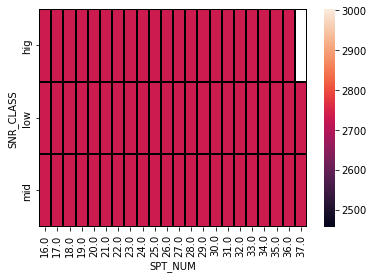

In [7]:
start = time.time()
newdf = addstars(singles,2730, mintype='', maxtype=37)

spt_snr = newdf.groupby('SNR_CLASS').SPT_NUM.value_counts().unstack()
sns.heatmap(spt_snr,annot=False,linewidths=0.1,linecolor='black')
end = time.time()

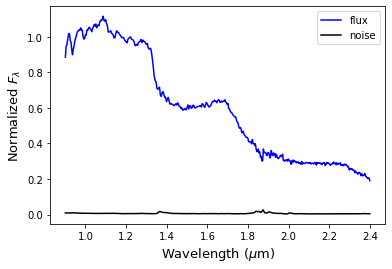

In [8]:
ii=1466
flux = newdf.FLUX[ii]
unc  = newdf.UNCERTAINTY[ii]
nflux, nunc = normalize(wave, flux, unc)
plt.plot(wave,nflux,c='b',label='flux')
plt.plot(wave,nunc,c='k',label='noise')
plt.xlabel('Wavelength ($\\mu$m)', size=13)
plt.ylabel('Normalized $F_\\lambda$', size=13)
plt.legend()
# plt.title('M7.0 flux, SNR= {snr:.2f}'.format(snr=newdf.UNCERTAINTY[ii]), size=14)
plt.savefig('paperfigures/ex_single_variednoise',facecolor='white')

In [9]:
syst_flux=[]
syst_noise=[]
for fluxflux, noisenoise in zip(newdf.FLUX,newdf.UNCERTAINTY):
    fluxflux2,noisenoise2 = normalize(wave,fluxflux,noisenoise)
    syst_flux.append(fluxflux2)
    syst_noise.append(noisenoise2)
newdf["FLUX"] = syst_flux
newdf["UNCERTAINTY"] = syst_noise
newdf.rename(columns={"FLUX":"system_interpolated_flux"},inplace=True)
newdf.rename(columns={"UNCERTAINTY":"system_interpolated_noise"},inplace=True)

flux_cols_dic = {}
for j in range(len(newdf['system_interpolated_flux'][0])):
    fluxcol=[]
    for i in range(len(newdf)):
        fluxcol.append(newdf['system_interpolated_flux'][i][j])
    fluxname='flux_'+str(j)
    flux_cols_dic[fluxname] = fluxcol
flux_cols_df = pd.DataFrame(flux_cols_dic)
newdf = pd.concat([newdf, flux_cols_df], axis=1)

newdf = newdf.sort_values(by=['SPT_NUM','J_SNR'], ascending=[True,False])
newdf = newdf.reset_index(drop=True)
newdf.head()

,system_interpolated_flux,system_interpolated_noise,J_SNR,SNR_CLASS,WAVE,SPT,SPT_NUM,flux_0,flux_1,flux_2,...,flux_399,flux_400,flux_401,flux_402,flux_403,flux_404,flux_405,flux_406,flux_407,flux_408
0,"[0.7265927080223364, 0.7617387019366572, 0.794...","[0.0022733376353015347, 0.002317339280722625, ...",855.886978,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0,0.726593,0.761739,0.794943,...,0.243965,0.244351,0.240435,0.234334,0.227850,0.224349,0.226685,0.227949,0.227389,0.225762
1,"[0.7288409133874643, 0.7589000995254457, 0.796...","[0.0025764536210179847, 0.002626322235743523, ...",753.814725,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0,0.728841,0.758900,0.796008,...,0.243954,0.244538,0.240948,0.233228,0.227914,0.224111,0.225528,0.228974,0.228057,0.225411
2,"[0.7319081708855486, 0.7588069089958512, 0.794...","[0.0026452051567653775, 0.002696404493619972, ...",737.335562,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0,0.731908,0.758807,0.794084,...,0.243436,0.243326,0.239290,0.236095,0.227286,0.225476,0.226031,0.228366,0.227662,0.227371
3,"[0.7236000532061864, 0.7610460552635769, 0.795...","[0.002638733481669213, 0.0026898075558490337, ...",736.306641,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0,0.723600,0.761046,0.795902,...,0.244692,0.243559,0.241610,0.233484,0.227091,0.225135,0.227858,0.226822,0.227336,0.226070
4,"[0.7240429872910842, 0.7685775481087592, 0.790...","[0.0027209802581784873, 0.0027736462619691107,...",713.323942,hig,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",M6.0,16.0,0.724043,0.768578,0.790617,...,0.243336,0.244582,0.239282,0.233153,0.227295,0.223572,0.226104,0.227036,0.227532,0.225032


In [64]:
SinDF_low = newdf[newdf.SNR_CLASS=='low'].reset_index(drop=True)
SinDF_mid = newdf[newdf.SNR_CLASS=='mid'].reset_index(drop=True)
SinDF_hig = newdf[newdf.SNR_CLASS=='hig'].reset_index(drop=True)

Text(0.5, 1.0, 'SNR Distribution')

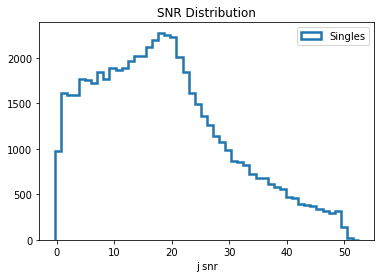

In [65]:
plt.hist(SinDF_low['J_SNR'],bins=50,lw=2.5, histtype='step', label='Singles')
plt.legend()
plt.xlabel('j snr')
plt.title('SNR Distribution')

In [66]:
with open('data/SinDF_low.pickle', 'wb') as f:
        pickle.dump(SinDF_low,f)
with open('data/SinDF_mid.pickle', 'wb') as f:
        pickle.dump(SinDF_mid,f)
with open('data/SinDF_hig.pickle', 'wb') as f:
        pickle.dump(SinDF_hig,f)